<a href="https://colab.research.google.com/github/Faizmeraj25/deep_learning_assigment1/blob/main/dl_q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


In [ ]:
print(x_test.shape)

(10000, 784)


In [ ]:
class NN: 
  # instantiate the weights and biases with random numbers. 
  def __init__(self, size): 
    self.W= [] 
    self.B = [] 
    self.preactivation = []
    self.activation = []
    for i in range(1, len(size)):
      w = np.random.rand(size[i], size[i-1]) /(np.sqrt(size[i]))
      b = np.random.rand(size[i]) 
      self.W.append(w)
      self.B.append(b)

###############################################################
  def normalize(self, x):
    for i in range(x.shape[0]):
      argmax = np.argmax(x[i])
      maxval = x[i][argmax]
      x[i] = (x[i])/(maxval)
    return x
###############################################################

  def sigmoid(self, x): 
    return 1/(1 + np.exp(-x))

###############################################################

  def sigmoid_derivative(self, x):
    sig = self.sigmoid(x)
    return sig*(1-sig)

###############################################################

  def relu(self, x): 
    return np.maximum(0, x)

###############################################################

  def relu_derivative(self, x):
    return np.max(np.sign(x),0)


###############################################################
    
  def tanh(self, x): 
    return np.tanh(x)

###############################################################

  def tanh_derivative(self, x):
    t = np.tanh(x)
    return 1 - t*t

###############################################################

  def softmax(self, x):
    for i in range(x.shape[0]):
      sum=0
      for j in range(x.shape[1]):
        sum=sum+np.exp(x[i][j])
      x[i]=np.exp(x[i])/sum
    return x

###############################################################

  def one_hot_encoded(self, y, size):
    return np.eye(size)[y]

###############################################################

  def cross_entropy(self, y_train, y_hat):
    loss=0
    for i in range (y_hat.shape[0]):
      loss+=-(np.log2(y_hat[i][y_train[i]]))
    return loss/y_hat.shape[0]

###############################################################

  def hadmard_mul(self, a, b):
    c = np.array(np.zeros((a.shape[0],a.shape[1])))
    for i in range(a.shape[0]):
      for j in range(a.shape[1]):
        c[i][j] = a[i][j] * b[i][j]
    return c

###############################################################
  def batch_converter(self, x, y, batch_size):
    no_datapoints = x.shape[0]
    no_batches = no_datapoints // batch_size
    x_batch = []
    y_batch = []
    for i in range(no_batches):
      s = i*batch_size
      e = min((i+1)*batch_size , x.shape[0])
      x1 = np.array(x[s:e])
      y1 = np.array(y[s:e])
      x_batch.append(x1)
      y_batch.append(y1)
    # jo datapoints last me bach jayenge wo yaha pe add kr rhe
    if no_batches * batch_size < x_train.shape[0]:
      x1 = np.array(x_train[no_batches* batch_size :])
      y1 = np.array(y_train[no_batches* batch_size :])
      x_batch.append(x1)
      y_batch.append(y1)
    return x_batch, y_batch


###############################################################

  def forward(self, input, size, activation_function = "sigmoid"):
    # Calculating for the hiddlen layers
    for i in range(len(size)-2):
      Y = np.dot(input, self.W[i].T)   + self.B[i]
      if i == 0 and activation_function.lower() == "relu":
        Y= self.normalize(Y)
      elif activation_function.lower() == "tanh":
        Y = self.normalize(Y)
      if i < len(self.preactivation):
        self.preactivation[i] = Y
      else:
        self.preactivation.append(Y)
      # Y_dash = self.normalize(Y)
      if activation_function.lower() == "relu":
        Z = self.relu(Y)
      elif activation_function.lower() =="sigmoid":
        Z = self.sigmoid(Y)
      elif activation_function.lower() =="tanh":
        Z = self.tanh(Y)
      else:
        print("NO ACTIVATION FUNCTION SELECTED")

      if i < len(self.activation):
        self.activation[i] = Z
      else:
        self.activation.append(Z)
      input = Z
    #Calculating for the output layer.
    i =  len(size)-2
    Y = np.dot(input, self.W[i].T) + self.B[i]
    # Y = self.normalize(Y)
    if i < len(self.preactivation):
        self.preactivation[i] = Y
    else:
      self.preactivation.append(Y)
    Z = self.softmax(Y)
    if i < len(self.activation):
        self.activation[i] = Z
    else:
        self.activation.append(Z)
    return self.preactivation, self.activation

###############################################################


  def backward(self, layers, x, y ,no_of_classes, preac, ac, activation_function="sigmoid"):
    no_layers = len(layers)
    grad_a = [] 
    grad_w = []
    grad_b = []
    grad_h = []
    y_onehot = self.one_hot_encoded(y, no_of_classes)
    grad_a.append(-(y_onehot - ac[len(ac)-1]))

    for i in range(no_layers-2, -1, -1):
      if i == 0:
        dw = (grad_a[no_layers-2-i].T @ x) #/ y.shape[0]
        db = np.sum(grad_a[no_layers-2-i],axis=0)/y.shape[0]
      else: 
        dw = (grad_a[no_layers-2-i].T @ ac[i-1])#/ y.shape[0]
        db = np.sum(grad_a[no_layers-2-i],axis=0)/ y.shape[0]
        dh_1 = grad_a[no_layers-2-i] @ self.W[i]
        sig = 0 
        if activation_function.lower() == "sigmoid":
          sig = self.sigmoid_derivative(preac[i-1])
        elif activation_function.lower() == "relu":
          sig = self.relu_derivative(preac[i-1])
        elif activation_function.lower() == "tanh":
          sig = self.tanh_derivative(preac[i-1])
        else:
          print("CANNOT UPDATE WEIGHT AND BIASES !!")

        da_1 = dh_1 * sig

        grad_h.append(dh_1)
        grad_a.append(da_1)
      grad_w.append(dw)
      grad_b.append(db)
    return grad_w, grad_b


###############################################################


  def gradient_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, eta, epochs):
    l = len(layers)
    loss_arr = []
    for ep in range(epochs):
      preac, ac = self.forward(x_train, layers, activation_function)
      grad_w, grad_b = self.backward(layers, x_train, y_train, no_of_classes, preac, ac, activation_function)

      for i in range(l-1):
        self.W[i] += -eta * grad_w[l-i-2]
        self.B[i] += -eta * grad_b[l-i-2]
      # print(ac[len(ac)-1])
      # preac, ac = self.forward(x, layers)
      loss = self.cross_entropy(y_train, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t", accur, "%")
    self.PlotError(loss_arr)



###############################################################


  def batch_grad_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, eta, batch_size, n_iterations):
    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    loss_arr = []
    for i in range(n_iterations):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes,preac, ac, activation_function)
        length = len(layers)
        for l in range(length-1):
          # print("shape",self.W[l].shape, grad_w[length-l-2].shape)
          self.W[l] += -eta * grad_w[length-l-2]
          self.B[l] += -eta * grad_b[length-l-2]
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", i+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)


###############################################################


  def momentum_grad_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epochs, beta):
    l = len(layers)
    prev_w = [] 
    prev_b = [] 
    loss_arr = []
    for i in range(l-1):
      prev_w.append(np.zeros(self.W[i].shape))
      prev_b.append(np.zeros(self.B[i].shape))

    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    for ep in range(epochs):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes, preac, ac, activation_function)
        for i in range(l-1):
          prev_w[i] = beta*prev_w[i] + grad_w[l-i-2]
          prev_b[i] = beta*prev_b[i] + grad_b[l-i-2]
          self.W[i] += -eta*prev_w[i]
          self.B[i] += -eta*prev_b[i]
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)


###############################################################

  def nesterov_gradient_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epochs, beta):
    l = len(layers)
    prev_w = []
    prev_b = []
    loss_arr = []
    for i in range(l-1):
      prev_w.append(np.zeros(self.W[i].shape))
      prev_b.append(np.zeros(self.B[i].shape))

    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    
    for ep in range(epochs):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        # print("y_hat", ac[len(ac)-1])
        for i in range(l-1):
          self.W[i] += -beta * prev_w[i]
          self.B[i] += -beta * prev_b[i]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes, preac, ac, activation_function)
        # print("grad_w", grad_w)
        for i in range(l-1):
          prev_w[i] = beta * prev_w[i] + grad_w[l-i-2]
          prev_b[i] = beta * prev_b[i] + grad_b[l-i-2]
          self.W[i] += -eta * prev_w[i]
          self.B[i] += -eta * prev_b[i]
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)



###############################################################


  def rmsprop_gradient_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epochs, beta):
    l = len(layers)
    vw = []
    vb = []
    loss_arr = []
    eps = 1e-4
    for i in range(l-1):
      vw.append(np.zeros(self.W[i].shape))
      vb.append(np.zeros(self.B[i].shape))

    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    for ep in range(epochs):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes, preac, ac, activation_function)
        for i in range(l-1):
          vw[i] = beta * vw[i] + (1-beta) * grad_w[l-i-2] * grad_w[l-i-2]
          vb[i] = beta * vb[i] + (1-beta) * grad_b[l-i-2] * grad_b[l-i-2]
          self.W[i] =  self.W[i] - (eta * grad_w[l-i-2])/np.sqrt(vw[i] + eps)
          self.B[i] =  self.B[i] - (eta * grad_b[l-i-2])/np.sqrt(vb[i] + eps)
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)


###############################################################


  def adam_gradient_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epochs, beta1, beta2):
    l = len(layers)
    mw = []
    mb = []
    vw = []
    vb = []
    loss_arr = []
    eps = 1e-10
    for i in range(l-1):
      vw.append(np.zeros(self.W[i].shape))
      vb.append(np.zeros(self.B[i].shape))
      mw.append(np.zeros(self.W[i].shape))
      mb.append(np.zeros(self.B[i].shape))
    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    for ep in range(epochs):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes, preac, ac, activation_function)
        for i in range(l-1):
          mw[i] = beta1 * mw[i] + (1-beta1) * grad_w[l-i-2]
          mb[i] = beta1 * mb[i] + (1-beta1) * grad_b[l-i-2]
          mw_hat = mw[i] / (1 - np.power(beta1, j+1))
          mb_hat = mb[i] / (1 - np.power(beta1, j+1))

          vw[i] = beta2 * vw[i] + (1-beta2) * grad_w[l-i-2] * grad_w[l-i-2]
          vb[i] = beta2 * vb[i] + (1-beta2) * grad_b[l-i-2] * grad_b[l-i-2]
          vw_hat = vw[i] / (1 - np.power(beta2, j+1))
          vb_hat = vb[i] / (1 - np.power(beta2, j+1))

          self.W[i] = self.W[i] - (eta * mw_hat)/(np.sqrt(vw_hat) + eps)
          self.B[i] = self.B[i] - (eta * mb_hat)/(np.sqrt(vb_hat) + eps)
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)

###############################################################


  def nadam_gradient_descent(self, x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epochs, beta1, beta2):
    l = len(layers)
    mw = []
    mb = []
    vw = []
    vb = []
    loss_arr = []
    eps = 1e-10
    for i in range(l-1):
      vw.append(np.zeros(self.W[i].shape))
      vb.append(np.zeros(self.B[i].shape))
      mw.append(np.zeros(self.W[i].shape))
      mb.append(np.zeros(self.B[i].shape))
    x_batch, y_batch = self.batch_converter(x_train, y_train, batch_size)
    for ep in range(epochs):
      for j in range(len(x_batch)):
        xb = x_batch[j]
        yb = y_batch[j]
        preac, ac = self.forward(xb, layers, activation_function)
        grad_w, grad_b = self.backward(layers, xb, yb, no_of_classes, preac, ac, activation_function)
        for i in range(l-1): 
          mw[i] = beta1 * mw[i] + (1-beta1)* grad_w[l-i-2]
          mb[i] = beta1 * mb[i] + (1-beta1)* grad_b[l-i-2]
          mw_hat = mw[i] / (1 - np.power(beta1, j+1))
          mb_hat = mb[i] / (1 - np.power(beta1, j+1))

          vw[i] = beta2 * vw[i] + (1-beta2) * grad_w[l-i-2] * grad_w[l-i-2]
          vb[i] = beta2 * vb[i] + (1-beta2) * grad_b[l-i-2] * grad_b[l-i-2]
          vw_hat = vw[i] / (1 - np.power(beta2, j+1))
          vb_hat = vb[i] / (1 - np.power(beta2, j+1))

          self.W[i] = self.W[i] - (eta/(np.sqrt(vw[i]) + eps)) * (beta1 * mw_hat + (((1-beta1) * grad_w[l-i-2]) / (1 - np.power(beta1, j+1))))
          self.B[i] = self.B[i] - (eta/(np.sqrt(vb[i]) + eps)) * (beta1 * mb_hat + (((1-beta1) * grad_b[l-i-2]) / (1 - np.power(beta1, j+1))))
      loss = self.cross_entropy(yb, ac[len(ac)-1])
      print("Iteration No : \t", ep+1, "\t Loss\t", loss)
      loss_arr.append(loss)
    accur = self.test_accuracy(layers, x_test, y_test, activation_function)
    print("Accuracy\t",accur, "%")
    self.PlotError(loss_arr)


###############################################################

  def test_accuracy(self, layers, x, y, activation_function):
    preac, ac = self.forward(x, layers, activation_function)
    y_pred = ac[len(ac)-1]
    err_count = 0
    for i in range(y_pred.shape[0]):
      maxval = -(math.inf)
      maxind= -1
      for j in range(y_pred.shape[1]): 
        if maxval < y_pred[i][j]:
          maxval = y_pred[i][j]
          maxind = j
      if maxind != y[i]:
        err_count = err_count + 1
    return ((y.shape[0] - err_count)/y.shape[0])*100
      
###############################################################
  def PlotError(self, ErrorSum):
    Iter = [] 
    for i in range(len(ErrorSum)):
      Iter.append(i)
    plt.plot(Iter,ErrorSum)
    plt.title('Error v/s Iteration')
    plt.xlabel('No of Iterations')
    plt.ylabel('Error')
    plt.show()


#Batch Gradient Descent

Iteration No : 	 1 	 Loss	 2.6437212823011995
Iteration No : 	 2 	 Loss	 1.6583600996885914
Iteration No : 	 3 	 Loss	 1.2607861839670054
Iteration No : 	 4 	 Loss	 1.139123465510059
Iteration No : 	 5 	 Loss	 1.0421914274210502
Iteration No : 	 6 	 Loss	 0.9347049972829721
Iteration No : 	 7 	 Loss	 0.8510326533825414
Iteration No : 	 8 	 Loss	 0.7971058487322693
Iteration No : 	 9 	 Loss	 0.7585313826711239
Iteration No : 	 10 	 Loss	 0.725391441512621
Accuracy	 82.42 %


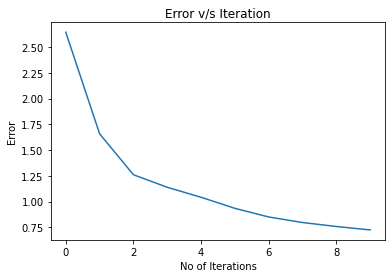

In [ ]:
epoch = 10
eta = 0.001
layers = [784, 256, 10]
no_of_classes = 10
nn = NN(layers)
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "sigmoid"
batch_size = 60

nn.batch_grad_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, eta, batch_size, epoch)


# Vanilla Gradient Descent

Iteration No : 	 1 	 Loss	 3.883192931516641
Iteration No : 	 2 	 Loss	 3.844319876002333
Iteration No : 	 3 	 Loss	 3.8080253419928973
Iteration No : 	 4 	 Loss	 3.7741412943249113
Iteration No : 	 5 	 Loss	 3.742510407529967
Accuracy	 5.06 %


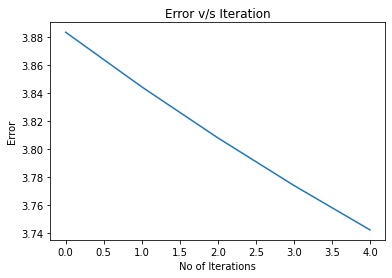

In [ ]:
epoch = 5
eta = 0.0000001
layers = [784, 128, 10]
no_of_classes = 10
nn = NN(layers)
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "tanh"
nn.gradient_descent(x_train, y_train,x_test, y_test, no_of_classes, layers, activation_function, eta, epoch)
  

# Momentum Gradient Descent

Iteration No : 	 1 	 Loss	 1.0734145436081675
Iteration No : 	 2 	 Loss	 0.9137191987498747
Iteration No : 	 3 	 Loss	 0.8568516981578325
Iteration No : 	 4 	 Loss	 0.716343832638946
Iteration No : 	 5 	 Loss	 0.9788435315220276
Iteration No : 	 6 	 Loss	 0.6715861302214643
Iteration No : 	 7 	 Loss	 0.6623957821103513
Iteration No : 	 8 	 Loss	 0.6779134845410295
Iteration No : 	 9 	 Loss	 0.6772902416006782
Iteration No : 	 10 	 Loss	 0.6473926603265818
Accuracy	 82.42 %


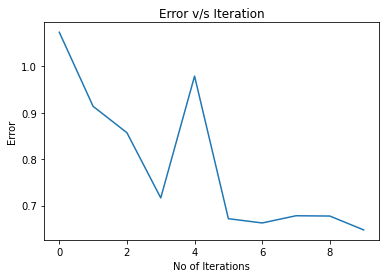

In [ ]:
epoch = 10
eta = 0.001
beta = 0.1
layers = [784, 128, 10]
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "tanh"
no_of_classes = 10
batch_size = 1024
nn = NN(layers)
nn.momentum_grad_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epoch, beta)

#Netserov Gradient Descent

Iteration No : 	 1 	 Loss	 1.5012899169928975
Iteration No : 	 2 	 Loss	 1.0240776040452584
Iteration No : 	 3 	 Loss	 0.8333523068231216
Iteration No : 	 4 	 Loss	 0.7839356261483988
Iteration No : 	 5 	 Loss	 0.7295523808341461
Iteration No : 	 6 	 Loss	 0.6828407250825632
Iteration No : 	 7 	 Loss	 0.657335983245861
Iteration No : 	 8 	 Loss	 0.6444943001818637
Iteration No : 	 9 	 Loss	 0.6262099193783176
Iteration No : 	 10 	 Loss	 0.6085917213466441
Accuracy	 83.41 %


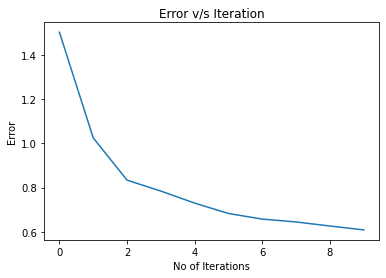

In [ ]:
epoch = 10
eta = 0.001
beta = 0.001
layers = [784, 128, 10]
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "Sigmoid"
no_of_classes = 10
batch_size = 1024
nn = NN(layers)
nn.nesterov_gradient_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epoch, beta)

# RMS Prop Gradient Descent

Iteration No : 	 1 	 Loss	 1.931525330026707
Iteration No : 	 2 	 Loss	 1.1954328061431283
Iteration No : 	 3 	 Loss	 0.9058842615311472
Iteration No : 	 4 	 Loss	 0.7673745825061116
Iteration No : 	 5 	 Loss	 0.6898940327237365
Iteration No : 	 6 	 Loss	 0.6420898120286201
Iteration No : 	 7 	 Loss	 0.6085613490881956
Iteration No : 	 8 	 Loss	 0.5844685335166118
Iteration No : 	 9 	 Loss	 0.5658240064655192
Iteration No : 	 10 	 Loss	 0.5506127631775349
Iteration No : 	 11 	 Loss	 0.5380366534236536
Iteration No : 	 12 	 Loss	 0.5272712649855645
Iteration No : 	 13 	 Loss	 0.5177945905115967
Iteration No : 	 14 	 Loss	 0.5092461863121375
Iteration No : 	 15 	 Loss	 0.5013050956118528
Iteration No : 	 16 	 Loss	 0.4941146193202872
Iteration No : 	 17 	 Loss	 0.4875749987301403
Iteration No : 	 18 	 Loss	 0.4815145742966712
Iteration No : 	 19 	 Loss	 0.47599420987795515
Iteration No : 	 20 	 Loss	 0.4708004166267894
Accuracy	 86.25 %


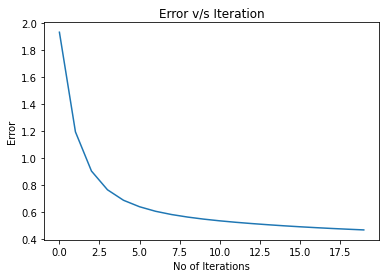

In [ ]:
epoch = 20
eta = 0.001
beta = 0.9
layers = [784, 128, 10]
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "sigmoid"
no_of_classes = 10
batch_size = 1024
nn = NN(layers)
nn.rmsprop_gradient_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epoch, beta)

# Adam Gradient Descent

Iteration No : 	 1 	 Loss	 0.7373635989868913
Iteration No : 	 2 	 Loss	 0.6058393088888391
Iteration No : 	 3 	 Loss	 0.5534002092095024
Iteration No : 	 4 	 Loss	 0.5205612772091172
Iteration No : 	 5 	 Loss	 0.4961253122501319
Iteration No : 	 6 	 Loss	 0.47664044719136084
Iteration No : 	 7 	 Loss	 0.4608388936439034
Iteration No : 	 8 	 Loss	 0.4495539911826278
Iteration No : 	 9 	 Loss	 0.43950010116729527
Iteration No : 	 10 	 Loss	 0.43107527100054494
Accuracy	 87.06 %


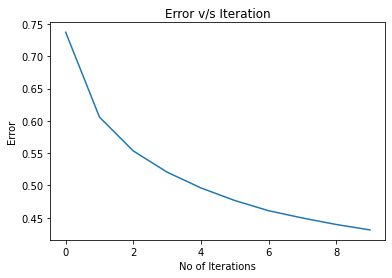

In [ ]:
epoch = 10
eta = 0.01
beta1 = 0.9
beta2 = 0.999
layers = [784, 128, 10]
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "sigmoid"
no_of_classes = 10
batch_size = 1024
nn = NN(layers)
nn.adam_gradient_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epoch, beta1, beta2)

# NAdam Gradient Descent

Iteration No : 	 1 	 Loss	 1.7754127500011123
Iteration No : 	 2 	 Loss	 1.3969621594779553
Iteration No : 	 3 	 Loss	 1.2274080964298577
Iteration No : 	 4 	 Loss	 1.0770809651044375
Iteration No : 	 5 	 Loss	 1.019123019487213
Iteration No : 	 6 	 Loss	 0.9748651503571305
Iteration No : 	 7 	 Loss	 0.9463185863693312
Iteration No : 	 8 	 Loss	 0.8730792054834119
Iteration No : 	 9 	 Loss	 0.8030447480257326
Iteration No : 	 10 	 Loss	 0.7811517070303758
Iteration No : 	 11 	 Loss	 0.7639120784160695
Iteration No : 	 12 	 Loss	 0.7393310865243649
Iteration No : 	 13 	 Loss	 0.725102354508218
Iteration No : 	 14 	 Loss	 0.7181269533518235
Iteration No : 	 15 	 Loss	 0.7084953002503241
Iteration No : 	 16 	 Loss	 0.6925882248027084
Iteration No : 	 17 	 Loss	 0.6774700108908491
Iteration No : 	 18 	 Loss	 0.6680489171600087
Iteration No : 	 19 	 Loss	 0.6732687625146365
Iteration No : 	 20 	 Loss	 0.6551444071035808
Accuracy	 82.01 %


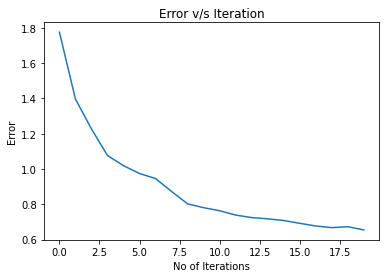

In [ ]:
epoch = 20
eta = 0.01
beta1 = 0.9
beta2 = 0.999
layers = [784, 128, 10]
# activation_function  : "relu", "tanh" , "sigmoid"
activation_function = "sigmoid"
no_of_classes = 10
batch_size = 1024
nn = NN(layers)
nn.nadam_gradient_descent(x_train, y_train, x_test, y_test, no_of_classes, layers, activation_function, batch_size, eta, epoch, beta1, beta2)